<a href="https://colab.research.google.com/github/ChinthakindhiNishitha/ML-LAB/blob/main/Assignment2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Original Dataset: (284807, 31)
Sampled Dataset: (40000, 31)
Before SMOTE: Class
0    39931
1       69
Name: count, dtype: int64
After SMOTE: Class
0    39931
1     7986
Name: count, dtype: int64

Random Forest Results:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      7987
           1       1.00      0.97      0.99      1597

    accuracy                           1.00      9584
   macro avg       1.00      0.99      0.99      9584
weighted avg       1.00      1.00      1.00      9584

ROC-AUC: 0.999925599198886


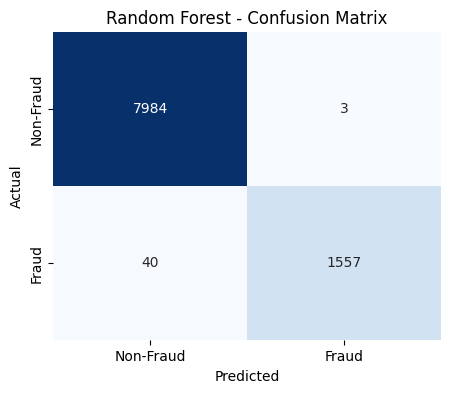


XGBoost Results:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      7987
           1       1.00      1.00      1.00      1597

    accuracy                           1.00      9584
   macro avg       1.00      1.00      1.00      9584
weighted avg       1.00      1.00      1.00      9584

ROC-AUC: 0.9999878481304818


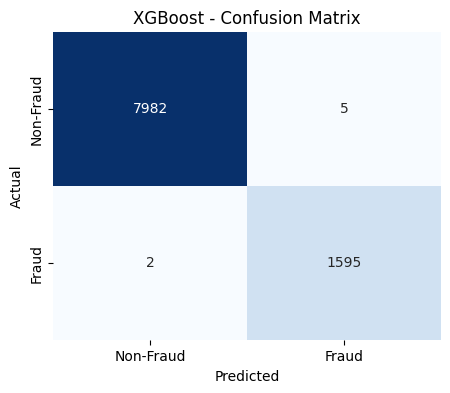


MLP Results:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      7987
           1       1.00      1.00      1.00      1597

    accuracy                           1.00      9584
   macro avg       1.00      1.00      1.00      9584
weighted avg       1.00      1.00      1.00      9584

ROC-AUC: 0.9999655043704002


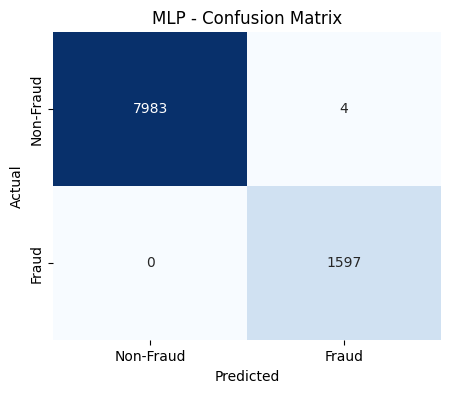


Stacked Ensemble Results:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      7987
           1       1.00      1.00      1.00      1597

    accuracy                           1.00      9584
   macro avg       1.00      1.00      1.00      9584
weighted avg       1.00      1.00      1.00      9584

ROC-AUC: 0.9999781266348675


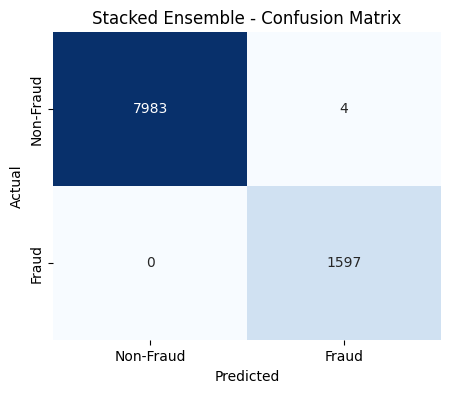


Model Comparison:
               Model  Accuracy   ROC-AUC
0     Random Forest  0.995513  0.999926
1           XGBoost  0.999270  0.999988
2               MLP  0.999583  0.999966
3  Stacked Ensemble  0.999583  0.999978


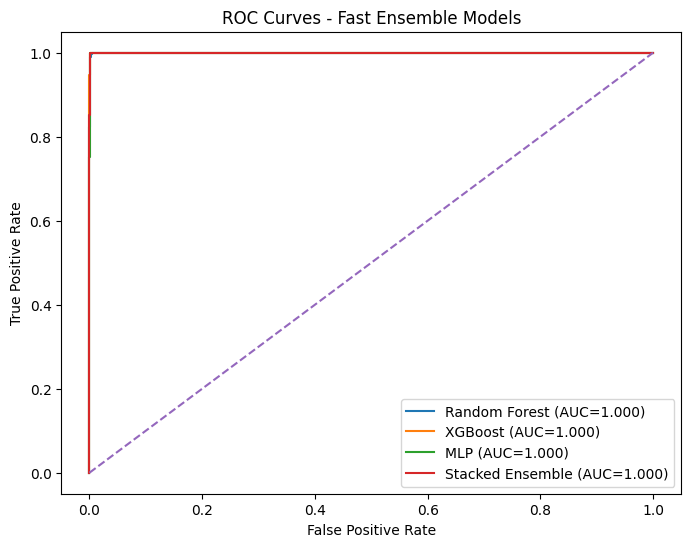

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, accuracy_score
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings('ignore')

# Step 1: Load dataset
df = pd.read_csv("/content/drive/MyDrive/creditcard.csv")
print("Original Dataset:", df.shape)

# Optional: Use only a smaller sample for speed
df = df.sample(n=40000, random_state=42)
print("Sampled Dataset:", df.shape)

# Step 2: Scale numerical features
scaler = StandardScaler()
df['scaled_amount'] = scaler.fit_transform(df['Amount'].values.reshape(-1, 1))
df['scaled_time'] = scaler.fit_transform(df['Time'].values.reshape(-1, 1))
df.drop(['Time', 'Amount'], axis=1, inplace=True)

# Reorder columns
scaled_amount = df['scaled_amount']
scaled_time = df['scaled_time']
df.drop(['scaled_amount','scaled_time'], axis=1, inplace=True)
df.insert(0, 'scaled_amount', scaled_amount)
df.insert(1, 'scaled_time', scaled_time)

# Step 3: Split data
X = df.drop('Class', axis=1)
y = df['Class']

# Optional: Apply SMOTE (partial balancing for speed)
print("Before SMOTE:", y.value_counts())
sm = SMOTE(random_state=42, sampling_strategy=0.2)
X_res, y_res = sm.fit_resample(X, y)
print("After SMOTE:", y_res.value_counts())

# Step 4: Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_res, y_res, test_size=0.2, random_state=42, stratify=y_res)

# Step 5: Define models
rf = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', n_estimators=100, max_depth=5, learning_rate=0.1)
mlp = MLPClassifier(hidden_layer_sizes=(64,), max_iter=150, random_state=42)

# Stacking ensemble
estimators = [('rf', rf), ('xgb', xgb), ('mlp', mlp)]
stack = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression(), n_jobs=-1)

# Step 6: Train all models
for model in [rf, xgb, mlp, stack]:
    model.fit(X_train, y_train)

# Step 7: Evaluate models
models = {"Random Forest": rf, "XGBoost": xgb, "MLP": mlp, "Stacked Ensemble": stack}
results = []

for name, model in models.items():
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]
    acc = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob)
    results.append({"Model": name, "Accuracy": acc, "ROC-AUC": auc})

    print(f"\n{name} Results:")
    print(classification_report(y_test, y_pred))
    print("ROC-AUC:", auc)

    # --- Confusion Matrix ---
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Non-Fraud', 'Fraud'],
                yticklabels=['Non-Fraud', 'Fraud'])
    plt.title(f'{name} - Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

# Step 8: Compare models
results_df = pd.DataFrame(results)
print("\nModel Comparison:\n", results_df)

# Step 9: ROC Curves
plt.figure(figsize=(8,6))
for name, model in models.items():
    y_prob = model.predict_proba(X_test)[:,1]
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    plt.plot(fpr, tpr, label=f"{name} (AUC={roc_auc_score(y_test, y_prob):.3f})")

plt.plot([0,1],[0,1],'--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves - Fast Ensemble Models")
plt.legend()
plt.show()


Original Dataset: (284807, 31)
Sampled Dataset: (40000, 31)
Before SMOTE: Class
0    39931
1       69
Name: count, dtype: int64
After SMOTE: Class
0    39931
1     7986
Name: count, dtype: int64

Random Forest Results:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      7987
           1       1.00      0.97      0.99      1597

    accuracy                           1.00      9584
   macro avg       1.00      0.99      0.99      9584
weighted avg       1.00      1.00      1.00      9584

ROC-AUC: 0.999925599198886

XGBoost Results:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      7987
           1       1.00      1.00      1.00      1597

    accuracy                           1.00      9584
   macro avg       1.00      1.00      1.00      9584
weighted avg       1.00      1.00      1.00      9584

ROC-AUC: 0.9999878481304818

MLP Results:
              precision    recall  f1-sc

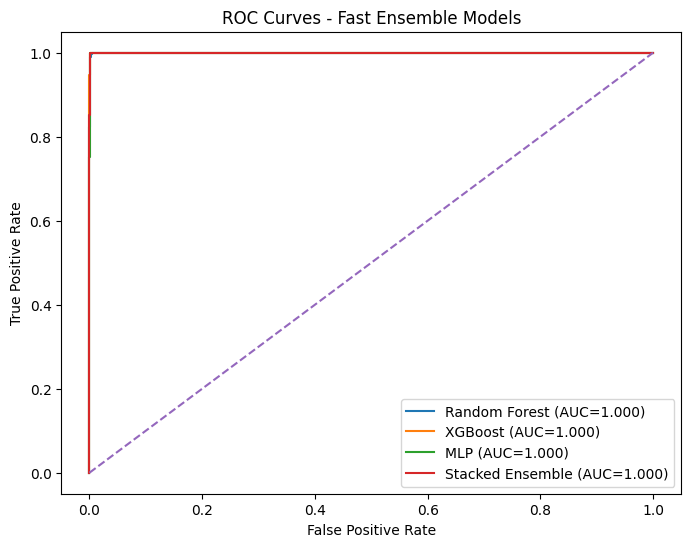

In [1]:
# ----------------------------------------------------
# Fast Ensemble Learning for Credit Card Fraud Detection
# ----------------------------------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, accuracy_score
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import StackingClassifier
import warnings
warnings.filterwarnings('ignore')

# Step 1: Load dataset
df = pd.read_csv("/content/drive/MyDrive/creditcard.csv")
print("Original Dataset:", df.shape)

# Optional: Use only a smaller sample for speed (say 40,000 rows)
df = df.sample(n=40000, random_state=42)
print("Sampled Dataset:", df.shape)

# Step 2: Scale numerical features
scaler = StandardScaler()
df['scaled_amount'] = scaler.fit_transform(df['Amount'].values.reshape(-1, 1))
df['scaled_time'] = scaler.fit_transform(df['Time'].values.reshape(-1, 1))
df.drop(['Time', 'Amount'], axis=1, inplace=True)

# Reorder columns
scaled_amount = df['scaled_amount']
scaled_time = df['scaled_time']
df.drop(['scaled_amount','scaled_time'], axis=1, inplace=True)
df.insert(0, 'scaled_amount', scaled_amount)
df.insert(1, 'scaled_time', scaled_time)

# Step 3: Split data
X = df.drop('Class', axis=1)
y = df['Class']

# Optional: Apply SMOTE (can skip if slow)
print("Before SMOTE:", y.value_counts())
sm = SMOTE(random_state=42, sampling_strategy=0.2)  # only balance partially for speed
X_res, y_res = sm.fit_resample(X, y)
print("After SMOTE:", y_res.value_counts())

# Step 4: Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2, random_state=42, stratify=y_res)

# Step 5: Define models (simpler configs)
rf = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', n_estimators=100, max_depth=5, learning_rate=0.1)
mlp = MLPClassifier(hidden_layer_sizes=(64,), max_iter=150, random_state=42)

# Step 6: Stacking ensemble
estimators = [('rf', rf), ('xgb', xgb), ('mlp', mlp)]
stack = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression(), n_jobs=-1)

# Step 7: Train all models
for model in [rf, xgb, mlp, stack]:
    model.fit(X_train, y_train)

# Step 8: Evaluate models
models = {"Random Forest": rf, "XGBoost": xgb, "MLP": mlp, "Stacked Ensemble": stack}
results = []

for name, model in models.items():
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:,1]
    acc = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob)
    results.append({"Model": name, "Accuracy": acc, "ROC-AUC": auc})
    print(f"\n{name} Results:")
    print(classification_report(y_test, y_pred))
    print("ROC-AUC:", auc)

# Step 9: Compare models
results_df = pd.DataFrame(results)
print("\nModel Comparison:\n", results_df)

# Step 10: ROC Curves
plt.figure(figsize=(8,6))
for name, model in models.items():
    y_prob = model.predict_proba(X_test)[:,1]
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    plt.plot(fpr, tpr, label=f"{name} (AUC={roc_auc_score(y_test, y_prob):.3f})")

plt.plot([0,1],[0,1],'--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves - Fast Ensemble Models")
plt.legend()
plt.show()
